In [1]:
from __future__ import print_function, division

# Basics

The LSL interface for DR spectrometer data is similar to that of DRX but there are a few key differences because they data have already been Fourier transformed and averaged in time.

First, download a snippet of DR spectrometer data:

In [1]:
# This may take a bit...
import os
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
from tempfile import mkdtemp
from lsl.reader import drx

TEMPDIR = mkdtemp()
DRS_FILE = os.path.join(TEMPDIR, 'temp.drspec')

fh1 = urlopen('https://lda10g.alliance.unm.edu/tutorial/B0329+54/056770_000044687')
fh2 = open(DRS_FILE, 'wb')
fh2.write(fh1.read(drx.FRAME_SIZE*300))
fh1.close()
fh2.close()

print("DR Spectrometer Size: %.1f kB" % (os.path.getsize(DRS_FILE)/1024.))

DR Spectrometer Size: 1209.4 kB


The contents of the file can be found using a few of the top-level functions in the lsl.reader.drspec module:

In [2]:
from lsl.reader import drspec

# Open the file
fh = open(DRS_FILE, 'rb')

# What is the size in bytes of each frame?
print("Frame size:", drspec.get_frame_size(fh), "bytes")

# What is the sample rate?
print("Sample Rate:", drspec.get_sample_rate(fh)/1e6, "MHz")

# How many frequency channels are in the data?
print("FFT length:", drspec.get_transform_size(fh), "channels")
print("-> %.3f kHz/channel" % (drspec.get_sample_rate(fh)/1e3/drspec.get_transform_size(fh),))

# What type of data do we have?
print("Linear (XX, YY, etc.)?", drspec.is_linear(fh))
print("Stokes (I, V, etc.)?", drspec.is_stokes(fh))

# What are the exact data products in the file?
print("Data products:", ", ".join(drspec.get_data_products(fh)))

# Close it out
fh.close()

Frame size: 16460 bytes
Sample Rate: 19.6 MHz
FFT length: 1024 channels
-> 19.141 kHz/channel
Linear (XX, YY, etc.)? True
Stokes (I, V, etc.)? False
Data products: XX, YY


To read in a single frame, use the modules read function:

In [3]:
# Open the file and read in a frame
fh = open(DRS_FILE, 'rb')
frame = drspec.read_frame(fh)

# Load in some basic information
beam = frame.id
srate = frame.sample_rate
LFFT = frame.transform_size
tInt = frame.integration_time

# Print out some basic information
print("Beam:", beam)
print("Timestamp:", frame.time)
print("Tuning 1:", frame.central_freq[0]/1e6, "MHz")
print("Tuning 2:", frame.central_freq[1]/1e6, "MHz")
print(" ")
print("Transform Length:", LFFT)
print("Integration Time:", tInt, "s")

# Done
fh.close()

Beam: 2
Timestamp: (1398276221, 0.034108066326530614)
Tuning 1: 54.40000092983246 MHz
Tuning 2: 73.99999976158142 MHz
 
Transform Length: 1024
Integration Time: 0.04012408163265306 s


The time tags reported in the above example are in split into a two-element tuple of integer seconds and fractional seconds since the UNIX epoch.  These can be converted to Python datetime instances through:

In [4]:
from datetime import datetime, timedelta

# Open the file and read in a frame
fh = open(DRS_FILE, 'rb')
frame = drspec.read_frame(fh)

# Load in some basic information
beam = frame.id
srate = frame.sample_rate
LFFT = frame.transform_size
tInt = frame.integration_time

# Deal with the time
frame_datetime = datetime.utcfromtimestamp(frame.time[0])
frame_datetime += timedelta(microseconds=int(frame.time[1]*1e6))

# Print out some basic information
print("Beam:", beam)
print("Timestamp:", frame_datetime)
print("Tuning 1:", frame.central_freq[0]/1e6, "MHz")
print("Tuning 2:", frame.central_freq[1]/1e6, "MHz")
print(" ")
print("Transform Length:", LFFT)
print("Integration Time:", tInt, "s")

# Done
fh.close()

Beam: 2
Timestamp: 2014-04-23 18:03:41.034108
Tuning 1: 54.40000092983246 MHz
Tuning 2: 73.99999976158142 MHz
 
Transform Length: 1024
Integration Time: 0.04012408163265306 s


The data product are stored as attributes to the frame.payload object.  You can either access these directly or through Python's getattr function:

In [5]:
# Open the file and read in a frame
fh = open(DRS_FILE, 'rb')
frame = drspec.read_frame(fh)

print("Tuning 1 XX mean:", frame.payload.XX0.mean())
print("Tuning 2 XX mean:", frame.payload.XX1.mean())
print(" ")

for tuning in (1, 2):
    for prod in frame.data_products:
        data = getattr(frame.payload, "%s%i" % (prod, tuning-1), None)
        print("Tuning %i %s standard deviation:" % (tuning, prod), data.std())

# Done
fh.close()

Tuning 1 XX mean: 27.688366
Tuning 2 XX mean: 10.287871
 
Tuning 1 XX standard deviation: 10.046879
Tuning 1 YY standard deviation: 9.770033
Tuning 2 XX standard deviation: 3.8569863
Tuning 2 YY standard deviation: 4.119423


# Plotting Spectra

Similar to DRX data you can also plot spectra from a DR spectrometer file.  However, unlink DRX data, you do not need to make a call to SpecMaster since they data have already been transformed:

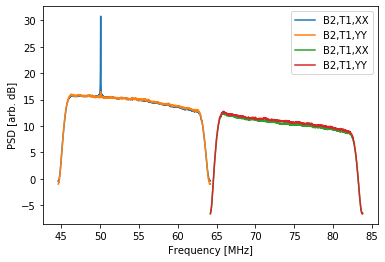

In [6]:
%matplotlib inline
import numpy
from lsl.misc.mathutil import to_dB
from matplotlib import pyplot as plt

# Open the file
fh = open(DRS_FILE, 'rb')

# Create the array that will hold the data
products = drspec.get_data_products(fh)
nprod = len(products)*2
nchan = drspec.get_transform_size(fh)
data = numpy.zeros((nprod, 5, nchan), dtype=numpy.float32)

# Read in the first 5 frames
for i in range(5):
    try:
        frame = drspec.read_frame(fh)
    except errors.SyncError:
        continue
    except errors.EOFError:
        break
        
    j = 0
    for tuning in (1, 2):
        for prod in products:
            data[j,i,:] = getattr(frame.payload, "%s%i" % (prod, tuning-1), None)
            j += 1
fh.close()

# Integrate across the frames
spec = data.mean(axis=1)

# Compute the frequency bins
freq = numpy.fft.fftfreq(spec.shape[1], d=1.0/frame.sample_rate)
freq = numpy.fft.fftshift(freq)
freq1 = freq + frame.central_freq[0]
freq2 = freq + frame.central_freq[1]

# Plot
beam = frame.id

fig = plt.figure()
ax = fig.gca()
for i in range(spec.shape[0]):
    if i // len(products) == 0:
        freq = freq1
    else:
        freq = freq2
        
    ax.plot(freq/1e6, to_dB(spec[i,:]), label='B%i,T1,%s' % (beam, products[i % len(products)]))
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()